In [1]:
using Gurobi, Cbc, Mosek, PyPlot, JuMP, Ipopt


# raw = readcsv("Book3.csv");
# # print(raw[3,4])
# trackx = length(raw[:,1])
# tracky = length(raw[1,:])


##track specs
starttrack = 28
finishtrack = 242
maintrack = 0
backgroundtrack = 255


## Tyre specs
coflo = 0.2 #coeffecient of friction longitudnal(in direction of motion)
cofla = 0.4 #coeffecient of friction lattitudnal(perpendicular to direction of motion of the front tyers when they turn)


## formula one car specs all specs in meters and seconds
# mass = 1000 # in kg
g = 9.8  # gravitational pull in m/sec^2
maxacc = 14.2 # max acc in m/sec^2
maxv = 103.55 # max velocity in m/sec equivalent to 200km/hr
maxTu = 1.27 #max steer one side

    
## Start ad Finish constraints
kstart =30 #28 optimal
extrak = 3 #probable extra time seconds
startPos = [50,1]
finishPos = [1000, 650]
startVel = [0,0]
finishVel = [0,0]
startAccDM = [0,0]
startAccCent = [0,0]
finishAccDM = [0,0]


function FindPath(CorPos,iterationsSet)
    ##model
    m = Model(solver = IpoptSolver(print_level=0))
    # m = Model(solver = GurobiSolver())
    
    kstarttemp = kstart
    extraktemp = extrak
    for i in 1:iterationsSet
        kstarttemp = kstarttemp*1.25
        extraktemp = extraktemp*1.25
    end
    kiteration = round(Int64,kstarttemp) #28 optimal
    extrakiteration = round(Int64,extraktemp) #
    
    ## Basic variables and their constraints
    @variable(m, P[1:2,1:kiteration])  # resulting position in x,y
    @variable(m, v[1:2,1:kiteration])
    @variable(m, -2.75*maxacc <= Thrust[1:kiteration] <= maxacc)  # thruster input
    @variable(m, AccDM[1:2,1:kiteration])
    @variable(m, AccDMBeta[1:kiteration])
    @variable(m, AccCent[1:2,1:kiteration])
    @constraint(m, P[:,1] .== startPos)
    @constraint(m, v[:,1] .== startVel)
    @constraint(m, AccCent[:,1] .== startAccCent)
    # @constraint(m, AccDM[:,1] .== startAccDM)
    @constraint(m, P[:,kiteration] .== finishPos)
    # @constraint(m, v[:,k] .== finishVel)
    # @constraint(m, AccDM[:,k] .== finishAccDM)
    # @NLexpression(m, finishDistance, sum((P[i,k]-finishPos[i])^2 for i in 1:2))
    @NLexpression(m, AccCentripital, sum((AccCent[1,i]^2)+(AccCent[2,i]^2)-(cofla*g)^2 for i in 1:kiteration))

    
    ## motion constraints
    for t in 1:kiteration
        @NLconstraint(m, AccDM[1,t]*AccCent[1,t] + AccDM[2,t]*AccCent[2,t] == 0)
    #     @constraint(m, (AccCent[1,t]^2)+(AccCent[2,t]^2) <= (cofla*g)^2)
        @NLconstraint(m, (AccCent[1,t]^2)+(AccCent[2,t]^2) <= 1500-(iterationsSet*50)) # (cofla*g)^2 = 15.3664
        @constraint(m, ((AccDM[1,t]^2)+(AccDM[2,t]^2)) <= (Thrust[t]- (coflo*g))^2)
        @constraint(m, (v[1,t]^2)+(v[2,t]^2) <= maxv^2)
    end
    for t in 2:kiteration-extrakiteration
        @constraint(m, (AccCent[1,t]^2)+(AccCent[2,t]^2) <= 999999*(((v[1,t]^2)+(v[2,t]^2))+((AccDM[1,t]^2)+(AccDM[2,t]^2)))) #|AccCent| > 0 only if (|v| > 0 || |AccDm| >0)
    end
    for t in 2:kiteration
        @NLconstraint(m, AccDM[1,t] == AccDMBeta[t]*(P[1,t]-P[1,t-1]))
        @NLconstraint(m, AccDM[2,t] == AccDMBeta[t]*(P[2,t]-P[2,t-1]))
    #     @constraint(m, AccDM[1,t]*(P[2,t]-P[2,t-1]) >=  AccDM[2,t]*(P[1,t]-P[1,t-1]))
    #     @constraint(m, AccDM[1,t]*(P[2,t]-P[2,t-1]) <=  AccDM[2,t]*(P[1,t]-P[1,t-1]))
    end
    @constraint(m, AccDM[2,1] >= 0)
    @constraint(m, AccDM[1,1] >= 0)
    @constraint(m, AccDM[1,1] <= 0)
    for t in 1:kiteration-1    
        @constraint(m, v[1,t+1] == v[1,t] + AccDM[1,t]  + AccCent[1,t])
        @constraint(m, v[2,t+1] == v[2,t] + AccDM[2,t]  + AccCent[2,t])  
        @constraint(m, P[1,t+1] == P[1,t] + v[1,t] + (.5)*(AccDM[1,t]  + AccCent[1,t])) 
        @constraint(m, P[2,t+1] == P[2,t] + v[2,t] + (.5)*(AccDM[2,t]  + AccCent[2,t]))     
    end

    
    ##minimize time section in first | time and velocity in second (by maximizing scarcity of velocity=0 at the ends)
    #start
    # @variable(m, t1[1:20])
    # for i in 1:20
    #     @constraint(m, sum((P[:,i]-startPos).^2) <= t1[i] )
    #     @constraint(m, sum((P[:,i]-startPos).^2) >= t1[i] )
    # end
    # @NLexpression(m, startPosDis1Norm, sum(t1[i] for i in 1:20))
    
    #finish
    @variable(m, t2[kiteration-extrakiteration:kiteration])
    @variable(m, t2v[kiteration-extrakiteration:kiteration])
    for i in kiteration-extrakiteration:kiteration
        @constraint(m, sum((P[:,i]-finishPos).^2) <= t2[i] )
        @constraint(m, sum((P[:,i]-finishPos).^2) >= t2[i] )
        @constraint(m, sum((v[:,i]-[0,0]).^2) <= t2v[i] )
        @constraint(m, sum((v[:,i]-[0,0]).^2) >= t2v[i] )
    end
    @NLexpression(m, finishPosDis1Norm, sum(t2[i]+t2v[i] for i in kiteration-extrakiteration:kiteration))
    
    #Both
    # @NLexpression(m, maxTimeByScarcity, startPosDis1Norm+finishPosDis1Norm)


    ##extra work
    # for t in 2:k-1
    #     @expression(m, v1, v[:,t+1]-v[:,t])
    #     @constraint(m, ((v1[2]*v[2,t]+v1[1]*v[1,t]))/((v1[1]^2+v[2]^2)*(v[1,t]^2+v[2,t]^2)) <= cos(maxTu))
    # #     @NLconstraint(m, (atan(v[2,t]/v[1,t])-atan(v[2,t+1]/v[1,t+1])) >= -maxTu)
    # end


    ## Track boundaries variables and constraints
    ## old track position respective time constraints
    # @constraint(m, P[2,:] .<=(3/2)*P[1,:] + 1100)
    for t in 1:round(Int64,(13*kiteration)/kstart)
        @constraint(m, P[1,t] >= 0)
        @constraint(m, P[1,t] <= 100)
        @constraint(m, P[2,t] >= 0)
        @constraint(m, P[2,t] <= 1300)
    end
    # for t in 12:13
    #     @constraint(m, P[1,t] >= 0)
    #     @constraint(m, P[1,t] <= 100)
    #     @constraint(m, P[2,t] >= 1000)
    #     @constraint(m, P[2,t] <= 1300)
    # end
    # for t in 15:15
    #     @constraint(m, P[1,t] >= 100)
    #     @constraint(m, P[1,t] <= 1600)
    #     @constraint(m, P[2,t] >= 1000)
    #     @constraint(m, P[2,t] <= 1300)
    # end
    for t in round(Int64,(16*kiteration)/kstart):round(Int64,(16*kiteration)/kstart)
        @constraint(m, P[2,t] >= 1200)
    end
    # # for t in 19:19
    # #     @constraint(m, P[2,t] >= 1200)
    # # end
    for t in round(Int64,(19*kiteration)/kstart):round(Int64,(22*kiteration)/kstart)
        @constraint(m, P[1,t] >= 500)
        @constraint(m, P[1,t] <= 600)
        @constraint(m, P[2,t] >= 600)
        @constraint(m, P[2,t] <= 1300)
    end
    for t in round(Int64,(23*kiteration)/kstart):kiteration
        @constraint(m, P[2,t] <= 700)
        @constraint(m, P[2,t] >= 600)
    end

    # new csv stuff (mostly helps for smoothing when time increases to reduce centripital force)
    for i in 1:iterationsSet
        temp = round(Int64,CorPos[1,i])
        if temp == 0
            temp = temp+1
        end
        for ksets in temp:round(Int64,temp*1.25)
            setvalue(P[1,ksets], CorPos[2,i]) 
            setvalue(P[2,ksets], CorPos[3,i])  
        end
    end   
    # @constraint(m, raw[getvalue(P[1,1]),getvalue(P[2,1])] >= starttrack)
    # @constraint(m, raw[getvalue(P[1,1]),getvalue(P[2,1])] <= starttrack)
    # for t in 2:k-1
    #     @constraint(m, raw[getvalue(P[1,t]),getvalue(P[2,t])] <= backgroundtrack-1)
    # end
    # @constraint(m, raw[getvalue(P[1,k]),getvalue(P[2,k])] >= finishtrack)
    # @constraint(m, raw[getvalue(P[1,k]),getvalue(P[2,k])] <= finishtrack)
    

    ## Objective function
    # @NLobjective(m, Min, finishDistance)
    # @NLobjective(m, Min, AccCentripital)
    # @NLobjective(m, Min, maxTimeByScarcity)
    # @NLobjective(m, Min, finishPosDis1Norm)
    @NLobjective(m, Min, AccCentripital + finishPosDis1Norm)
    solve(m)
    
    
    ##function return stuff
    positions = getvalue(P)
    return(positions)
end


FindPath (generic function with 1 method)

In [2]:
using JuMP, Gurobi, PyPlot
raw = readcsv("Book1.csv");
# print(raw[103,1])
trackx = length(raw[:,1])
tracky = length(raw[1,:])
raw[1,1] = 28
iterations = 5

finalposSize =zeros(iterations) 
finalposSize[1] = kstart
for i in 2:iterations
    finalposSize[i] = finalposSize[i-1]*1.25
end
position = 150*ones(iterations,2,round(Int64, finalposSize[iterations]))

blankpos = [3;50;100]
position[1,:,1:round(Int64,finalposSize[1])] = FindPath(blankpos,0)

for iteration = 2:iterations
    println("I am 1")
    posCounter = 0
    println("iteration:", iteration)
    for w in 1:length(position[iteration-1,1,:])
        println("I am 1.1 :" ,w)
        tempx = round(Int64, position[iteration-1,1,w])
        tempy = round(Int64, position[iteration-1,2,w])
        if tempx == 0
            tempx = tempx+1
        end
        if tempy == 0
            tempy = tempy+1
        end
        if raw[tempx, tempy] < 255
#             println("raw[",tempx,",",tempy,"] = ",raw[tempx, tempy])
            posCounter = posCounter+1
        end
    end
    if posCounter < length(position[iteration-1,1,:])
        println("I am 1.2")
        CorPos = [zeros(posCounter)'; zeros(posCounter)';zeros(posCounter)']
        hits = 1
        for w in 1:length(position[iteration,1,:])
#             println("I am 1.3")
            tempx =  round(Int64, position[iteration-1,1,w]) 
            tempy =  round(Int64, position[iteration-1,2,w]) 
            if tempx == 0
                tempx = tempx+1
            end
            if tempy == 0
                tempy = tempy+1
            end
            posNumber = round(Int64, raw[tempx,tempy])
            if posNumber < 255
                CorPos[1,hits] = w
                CorPos[2,hits] = position[iteration-1,1,w]
                CorPos[3,hits] = position[iteration-1,2,w]
                hits = round(Int64, hits + 1)
            end
        end
        position[iteration,:,1:round(Int64,finalposSize[iteration])] = FindPath(CorPos,iteration-1)
    end
end

LoadError: [91mUndefVarError: k not defined[39m

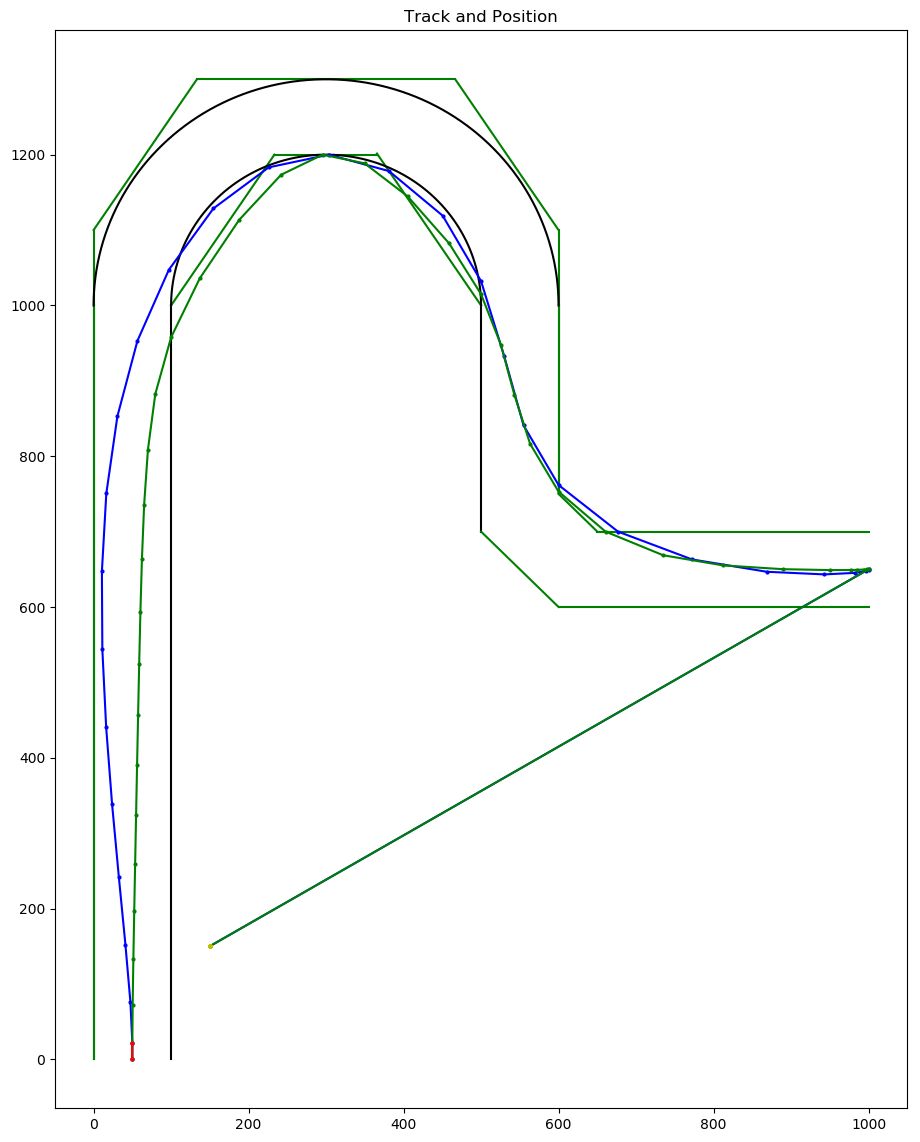

In [102]:
## Plotting everything
#Plotting track (Position plots will also go in same figure)
rad = linspace(0,π,100) 
x = 300 + 200*cos.(rad)
y = 1000 + 200*sin.(rad)
x1 = 300 + 300*cos.(rad)
y1 = 1000 + 300*sin.(rad)
x2 = linspace(0,133.33,100)
x3 = linspace(100,233.33,100)
x4 = linspace(233.33,365.66,100)
x5 = linspace(133.33,466.66,100)
x6 = linspace(365.66,500,100)
x7 = linspace(466.66,600,100)
y2 = (3/2)*x2 + 1100
y3 = (3/2)*x3 + 850
y4 = 0*x4 + 1200
y5 = 0*x5 + 1300
y6 = -(3/2)*x6 + 1750
y7 = -(3/2)*x7 + 2000
x8 = linspace(0,0,2)
x9 = linspace(600,600,2)
y8 = linspace(0,1100,2)
y9 = linspace(750,1100,2)
x10 = linspace(500,600,100)
x11 = linspace(600,650,100)
x12 = linspace(600,1000,100)
x13 = linspace(650,1000,100)
y10 = -x10 + 1200
y11 = -x11 + 1350
y12 = 0*x12 + 600
y13 = 0*x13 + 700
Llinex = [0, 0]
Lliney = [0, 1000]
LMlinex = [100,100]
LMliney = [0,1000]
RMlinex = [500, 500]
RMliney = [700,1000]
Rlinex = [600,600]
Rliney = [750,1000]
figure(figsize=(11,14))
title("Track and Position")
#Track
plot(Llinex[:],Lliney[:], color = "#000000", markersize=4 )
plot(LMlinex[:],LMliney[:],color = "#000000", markersize=4 )
plot(RMlinex[:],RMliney[:], color = "#000000", markersize=4 )
plot(Rlinex[:],Rliney[:], color = "#000000", markersize=4 )
plot(x2,y2, "g-", markersize=4 )
plot(x3,y3, "g-", markersize=4 )
plot(x4,y4, "g-", markersize=4 )
plot(x5,y5, "g-", markersize=4 )
plot(x6,y6, "g-", markersize=4 )
plot(x7,y7, "g-", markersize=4 )
plot(x8,y8, "g-", markersize=4 )
plot(x9,y9, "g-", markersize=4 )
plot(x10,y10, "g-", markersize=4 )
plot(x11,y11, "g-", markersize=4 )
plot(x12,y12, "g-", markersize=4 )
plot(x13,y13, "g-", markersize=4 )
plot(x,y, color = "#000000", markersize=4 )
plot(x1,y1, color = "#000000", markersize=4 )
#Position
plot( position[1,1,:], position[1,2,:], "b.-", markersize=4 )
plot( position[2,1,:], position[2,2,:], "g.-", markersize=4 )
plot( position[3,1,:], position[3,2,:], "r.-", markersize=4 )
plot( position[4,1,:], position[4,2,:], "y.-", markersize=4 )
# plot( getvalue(P[1,:]), getvalue(P[2,:]), "b.-", markersize=4 )
# plot( getvalue(P[1,10]), getvalue(P[2,10]), "y.", markersize=4 )
# plot( getvalue(P[1,20]), getvalue(P[2,20]), "r.", markersize=4 )
# plot( getvalue(P[1,30]), getvalue(P[2,30]), "g.", markersize=4 )
# # plot( getvalue(P[1,40]), getvalue(P[2,40]), "y.", markersize=4 )
# axis((-50,1050,-50,1350));

# figure(figsize=(12,4))
# title("velocity x")
# plot( getvalue(v[1,:]), "b.", markersize=2 )

# figure(figsize=(12,4))
# title("velocity y")
# plot( getvalue(v[2,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in direction of motion x")
# plot( getvalue(AccDM[1,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in direction of motion y")
# plot( getvalue(AccDM[2,:]), "b-", markersize=2 )

# figure(figsize=(12,40))
# title("Acceleration centripital(green), DM(red), V(blue)")
# plot( getvalue((AccCent[1,:].^2)+(AccCent[2,:].^2)), "g-", markersize=2 )
# plot( getvalue((AccDM[1,:].^2)+(AccDM[2,:].^2)), "r-", markersize=2 )
# plot( getvalue((v[1,:].^2)+(v[2,:].^2)), "b-", markersize=2 )#, yscale = :log10)

# figure(figsize=(12,4))
# title("Acceleration in centripital of motion x")
# plot( getvalue(AccCent[1,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in centripital of motion y")
# plot( getvalue(AccCent[2,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("AccDMBeta")
# plot( getvalue(AccDMBeta), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Thrust")
# plot( getvalue(Thrust), "b-", markersize=2 )